### Cars Location Detection

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import keras

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from nms import non_max_suppression_fast

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
import csv

import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.


In [2]:
model_path = os.path.join('snapshots', 'inference', 'grab_inference_6_july_19.h5')

model = models.load_model(model_path, backbone_name='resnet50')

c:\program files\python\python36\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
def process_image(path):
    image = read_image_bgr(path)
    draw_bgr = image.copy()
    draw = cv2.cvtColor(draw_bgr, cv2.COLOR_BGR2RGB)

    image = preprocess_image(image)
    image, scale = resize_image(image)

    boxes, scores, labels = model.predict(np.expand_dims(image, axis=0))
    boxes /= scale

    box_nms, scores_nms, labels_nms = non_max_suppression_fast(boxes[0], 0.3, scores[0], labels[0])

    for box, score, label in zip(box_nms, scores_nms, labels_nms):
        if score < 0.2:
            break
        color = (0, 255, 0)
        (x1, y1, x2, y2) = box
        draw_box(draw, box, color=color, thickness=4)
    
    crop_image = draw_bgr[y1 : y1 + (y2-y1), x1 : x1 + (x2-x1)]
    new_path = 'crop/{}'.format(path)
    cv2.imwrite(new_path, crop_image)
    
    return draw

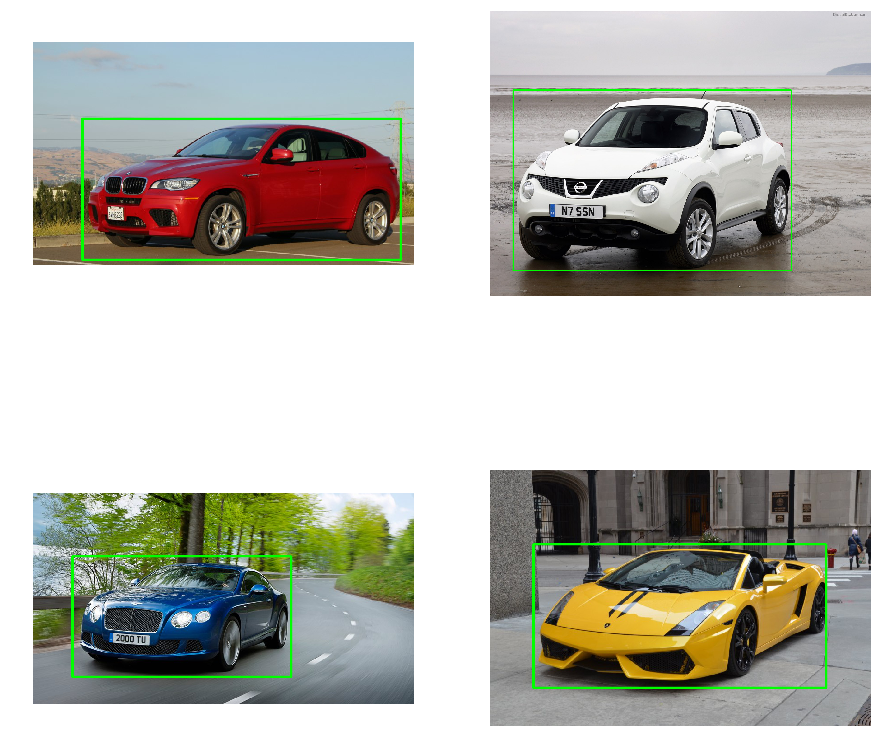

In [4]:
car_1 = process_image('extra/images/extra-car_1.jpg')
car_2 = process_image('extra/images/extra-car_2.jpg')
car_3 = process_image('extra/images/extra-car_3.jpg')
car_4 = process_image('extra/images/extra-car_4.jpg')

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1), plt.imshow(car_1), plt.axis('off')
plt.subplot(2, 2, 2), plt.imshow(car_2), plt.axis('off')
plt.subplot(2, 2, 3), plt.imshow(car_3), plt.axis('off')
plt.subplot(2, 2, 4), plt.imshow(car_4), plt.axis('off')
plt.show()

### Cars make and model detection

In [5]:
from keras.models import load_model
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input
import numpy as np
import csv

car_dictionary = {}

with open('cars/devkit/class.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        car_name = row[0]
        car_id = int(row[1])
        car_dictionary[car_id] = car_name

model = load_model('cars/densenet169sgdpadclass-epochs-15-0.22.h5')

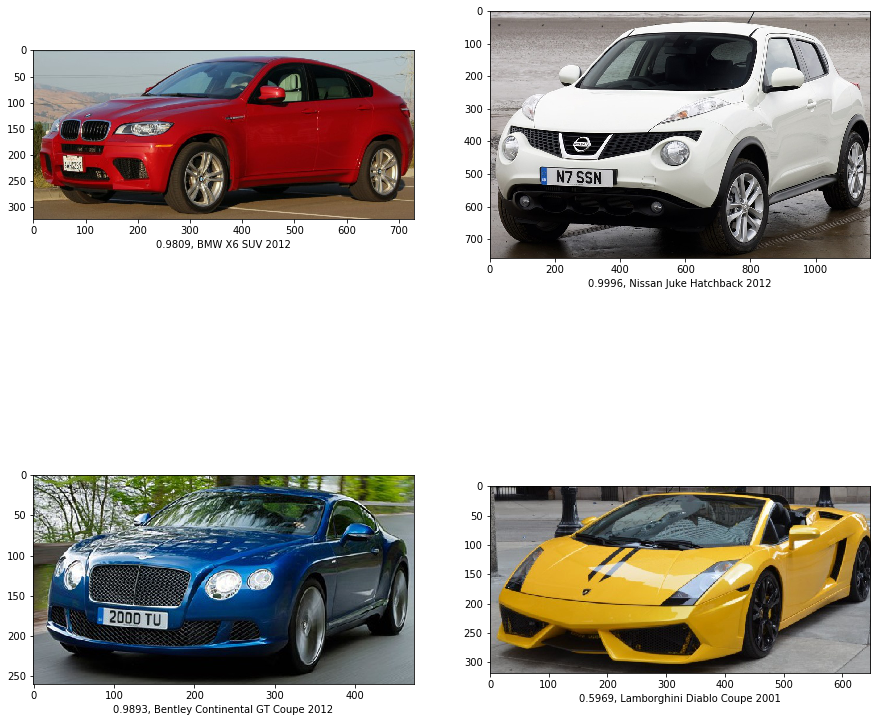

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 15))

for i in range(4):
    img_path = 'crop/extra/images/extra-car_{}.jpg'.format(i+1)
    img_plot = image.load_img(img_path)
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    preds = model.predict(x)
    cat_preds = np.argmax(preds) + 1
    prob = np.max(preds)
    label = '{:.4f}, {}'.format(prob, car_dictionary[cat_preds])
    plt.subplot(2, 2, i+1), plt.imshow(img_plot), plt.xlabel(label)
    
plt.show()